In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector
import numpy as np
db = mysql.connector.connect( host='localhost',
    user='root',
    password='ameen@123',
    database='ecommerce'
)

cur = db.cursor()

# list all the cities where customers are located 

In [4]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

data = pd.DataFrame(data)

data

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [5]:
query = """ select count(distinct order_id) from orders
where year(order_purchase_timestamp)= 2017"""

cur.execute(query)

data = cur.fetchall()

" Total orders placed in 2017",data[0][0]

(' Total orders placed in 2017', 45101)

## Count the number of orders placed in 2018

In [6]:
query = """ select count(distinct order_id) from orders
where year(order_purchase_timestamp)= 2018"""

cur.execute(query)

data = cur.fetchall()

" Total orders placed in 2018",data[0][0]

(' Total orders placed in 2018', 54011)

# Observation 
* Orders increased from 45,101 in 2017 to 54,011 in 2018, showing a ~19.8% YoY growth.


## Total sales per category 

In [37]:
query = """ select upper(products.product_category),round(sum(payments.payment_value)) as total_sales 
from products 
join order_items on order_items.product_id = products.product_id
join payments on payments.order_id=order_items.order_id
group by products.product_category
order by total_sales desc
"""

cur.execute(query)

data = cur.fetchall()

data =  pd.DataFrame(data,columns = ["Category","Totalsales"])
data.head(5)

,Category,Totalsales
0,BED TABLE BATH,3425107.0
1,HEALTH BEAUTY,3314746.0
2,COMPUTER ACCESSORIES,3170661.0
3,FURNITURE DECORATION,2860353.0
4,WATCHES PRESENT,2858433.0


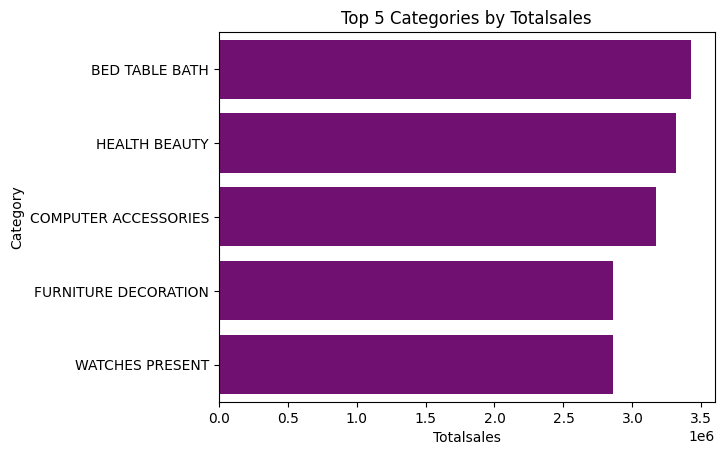

In [39]:
top5 = data.nlargest(5, "Totalsales")   # take top 5 rows
sns.barplot(x="Totalsales", y="Category", data=top5,color="purple")
plt.title("Top 5 Categories by Totalsales")
plt.show()

# Observation
** The Bed, Table, Bath category leads with 3.4M in sales, showing strong demand for household essentials.
* Health & Beauty and Computer Accessories are also top contributors (~3.3M & 3.1M), highlighting consumer spending in personal care and tech products.
* Categories like Furniture Decoration and Watches & Presents (~2.8M each) indicate a growing lifestyle and gifting market.
* Insight: The business can prioritize inventory & marketing around these top categories to maximize revenue impact.

## Calculate percentage of the orders that paid by installment

In [9]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end )/count(*))*100
           from payments"""

cur.execute(query)

data = cur.fetchall()
data

[(Decimal('99.9981'),)]

- Nearly all customers (≈100%) prefer installment-based payments over one-time payments.
- This shows that the platform’s installment option is a key enabler of sales, making products more accessible and boosting overall order volume.
- Business Insight: The company should maintain and expand installment schemes (e.g., EMI partnerships with banks), since removing or           limiting them could badly reduce sales.

## count the number of customers each state

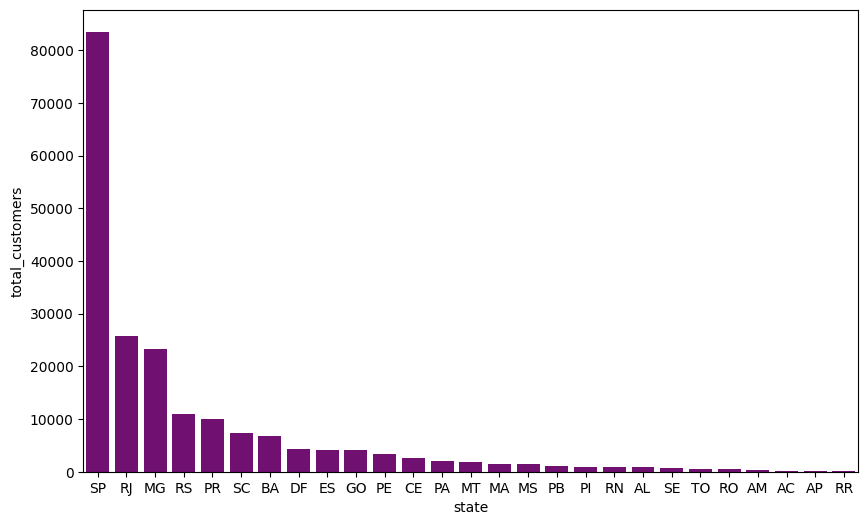

In [35]:
query="""select customer_state,count(customer_state) as total_customers 
         from customers 
         group by 1
         order by total_customers desc"""
cur.execute(query)

data = cur.fetchall()
data=pd.DataFrame(data,columns=["state","total_customers"])
plt.figure(figsize=(10,6))
a=sns.barplot(x = "state", y = "total_customers", data = data,color="purple")
plt.show()

# Observatio
* SP dominates with 83.5K customers, the largest share in the dataset.
* RJ and MG follow with ~25.7K and 23.2K customers respectively.
* Other high-customer states: RS, PR, SC.
* Customer base is heavily concentrated in a few states (SP, RJ, MG), while smaller states (RR, AP, AC) have minimal representation.
* Business Insight: The company should focus logistics and marketing resources in SP, RJ, and MG to capture maximum sales impact.

# Calculate the total number of orders per month in 2018

In [14]:
query="""select month(order_purchase_timestamp) as month,count(order_id) as total_orders
from orders 
where year(order_purchase_timestamp) = 2018
group by month
order by month asc"""

cur.execute(query)

data = cur.fetchall()
data=pd.DataFrame(data,columns=["Month","Total_Customers"])
data

,Month,Total_Customers
0,1,14538
1,2,13456
2,3,14422
3,4,13878
4,5,13746
5,6,12334
6,7,12584
7,8,13024
8,9,32
9,10,8


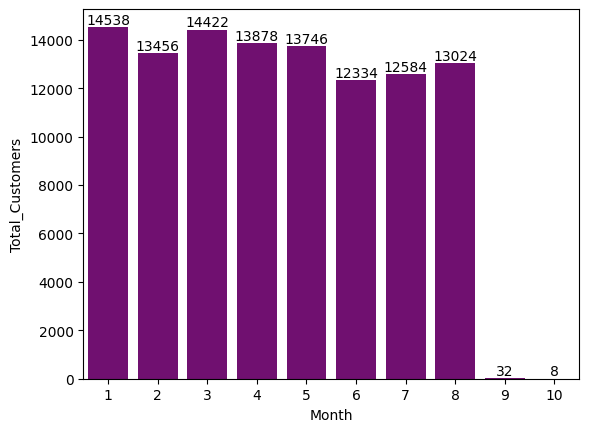

In [15]:
ax=sns.barplot(x=data["Month"],y=data["Total_Customers"],data=data,color="purple")
ax.bar_label(ax.containers[0])
plt.show()

# Find the avg number of products per orders group by city 

In [16]:
query="""with counts as (
select o.order_id,o.customer_id,count(p.order_id) as count_of_orders 
from orders o 
join payments p on p.order_id=o.order_id
group by o.order_id,o.customer_id)

select cs.customer_city,avg(count_of_orders) as avg_orders 
from customers cs
join counts c on cs.customer_id=c.customer_id
group by cs.customer_city
order by avg_orders desc"""

cur.execute(query)

data = cur.fetchall()
data =  pd.DataFrame(data,columns = ["City","Avg orders"])

data.head(10)

,City,Avg orders
0,santa cecilia do pavao,6.0000
1,anhandui,6.0000
2,itaqui,4.4444
3,mata verde,4.3333
4,sao jorge do ivai,4.0000
5,taperuaba,4.0000
6,perola d'oeste,4.0000
7,santa barbara d oeste,4.0000
8,igaracu do tiete,4.0000
9,brejoes,4.0000


# Observation 
- Cities such as Santa Cecília do Pavão and Anhandui recorded the highest average orders per customer (~6).
- Many cities like Itaqui, Mata Verde, and São Jorge do Ivaí show averages around 4 orders per customer.
- The results highlight clear variation in order frequency across cities.

# Calculate total percentage of revenue contributing each product_category 

In [20]:
query="""SELECT UPPER(p.product_category) AS product_category,
    ROUND(SUM(pm.payment_value) / (SELECT SUM(payment_value) FROM payments) * 100, 2) AS total_sales
FROM products p
JOIN order_items oi 
    ON oi.product_id = p.product_id
JOIN payments pm 
    ON pm.order_id = oi.order_id
GROUP BY p.product_category
ORDER BY total_sales DESC"""

cur.execute(query)

data = cur.fetchall()

cur.execute(query)

data = cur.fetchall()
data =  pd.DataFrame(data,columns = ["Products_Categories","Revenue_percentage"])
data.head(10)

,Products_Categories,Revenue_percentage
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


# Observation
- Bed Table Bath (21.40%) and Health Beauty (20.71%) are the two largest contributors, together making up over 42% of total sales.
- Categories like Computer Accessories (19.81%), Furniture Decoration (17.87%), and Watches Present (17.86%) also show strong contributions.
- The top 5 categories alone account for ~98% of sales, showing a highly concentrated distribution across limited categories.

# Identify correlations between product price and the number of time product has been purchassed 

In [23]:
query="""SELECT P.product_category,count(p.product_id) as order_counts,
round(avg(oi.price)) as avg_price from products p 
join order_items oi on p.product_id=oi.product_id
group by p.product_category"""

cur.execute(query)

data = cur.fetchall()
data = pd.DataFrame(data,columns=["product_category","order_counts","avg_price"])
data
array1=data["order_counts"]
array2=data["avg_price"]
ax=np.corrcoef([array1,array2])
ax


array([[ 1.       , -0.1064395],
       [-0.1064395,  1.       ]])

# Observation 
- The correlation between product price and purchase frequency is -0.106.
- This shows only a very weak negative relationship.
- In simple terms, price has almost no significant impact on how often products are purchased.

# Calculate total revenue generated by each celler and rank them by revenue

In [25]:
query="""WITH x AS (
    SELECT 
        oi.seller_id,
        ROUND(SUM(p.payment_value)) AS total_revenue
    FROM payments p 
    JOIN order_items oi ON oi.order_id = p.order_id
    GROUP BY oi.seller_id
)
SELECT 
    seller_id,
    total_revenue,
    dense_rank() OVER (ORDER BY total_revenue DESC) AS revenue_rank
FROM x;
"""

cur.execute(query)

data = cur.fetchall()
data = pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])
data=data.head(10)
data


,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507167.0,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.0,2
2,4a3ca9315b744ce9f8e9374361493884,301245.0,3
3,1f50f920176fa81dab994f9023523100,290253.0,4
4,53243585a1d6dc2643021fd1853d8905,284903.0,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.0,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.0,7
7,955fee9216a65b617aa5c0531780ce60,236322.0,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.0,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.0,10


# Obseration 
- The top seller earned about 507K revenue, which is much higher than others.
- The 2nd and 3rd sellers made around 308K and 301K.
- Overall, the top 10 sellers are the biggest revenue contributors, with a clear gap between rank 1 and the rest.

# Calculate cumulative sales per month for each year

In [29]:
query="""select years,months,total_revenue,sum(total_revenue)over(order by years,months) as cumulative_sales
from(
select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value)) as total_revenue
from orders o 
join payments p on o.order_id=p.order_id
group by years,months
order by years,months) as a"""

cur.execute(query)

data = cur.fetchall()
data = pd.DataFrame(data,columns=["Years","Months","total_revenue","cumulative_sales"])
# data.head(5)
data

,Years,Months,total_revenue,cumulative_sales
0,2016,9,504.0,504.0
1,2016,10,118181.0,118685.0
2,2016,12,39.0,118724.0
3,2017,1,276976.0,395700.0
4,2017,2,583816.0,979516.0
5,2017,3,899727.0,1879243.0
6,2017,4,835576.0,2714819.0
7,2017,5,1185838.0,3900657.0
8,2017,6,1022553.0,4923210.0
9,2017,7,1184766.0,6107976.0


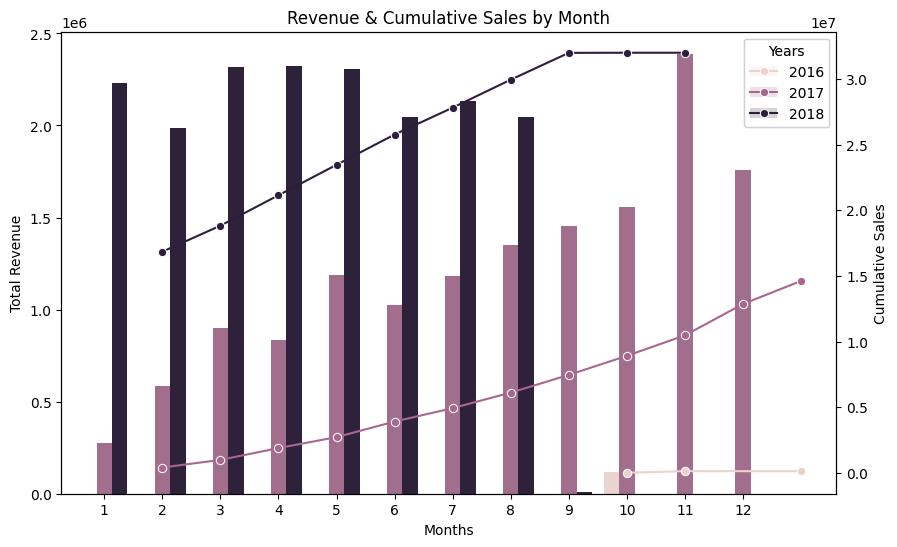

In [30]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bars for total revenue
sns.barplot(x="Months", y="total_revenue", hue="Years", data=data, estimator=sum)
            # , ax=ax1, alpha=0.7)

# Line for cumulative sales
ax2 = ax1.twinx()
sns.lineplot(x="Months", y="cumulative_sales", hue="Years", data=data, marker="o", ax=ax2)

ax1.set_ylabel("Total Revenue")
ax2.set_ylabel("Cumulative Sales")
ax1.set_title("Revenue & Cumulative Sales by Month")

plt.show()


# Calculate year to year growth 

In [31]:
query="""with x as (select year(o.order_purchase_timestamp) as years,
round(sum(p.payment_value)) as total_revenue
from orders o 
join payments p on o.order_id=p.order_id
group by years
order by years)

select years,
round(((total_revenue-lag(total_revenue)over(order by years))/lag(total_revenue)over(order by years))*100,2) as Growth
from x"""

cur.execute(query)

data = cur.fetchall()
data = pd.DataFrame(data,columns=["Years","Growth"])
data

,Years,Growth
0,2016,NaN
1,2017,12112.67
2,2018,20.00


# Observation
- From 2016 → 2017, growth is about 12,112%, showing a massive jump.
- From 2017 → 2018, growth slowed to just 20%.

# Calculate retention rate of customers define as the percentage of customers who make another purchase within 6 month of their first purchase

In [32]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Observation 
- The calculation shows 0% retention — no customers made a repeat purchase within 6 months of their first order.
- This means all customers purchased only once in the given period.

# Identify the top 3 customers who spent the most money in each year.

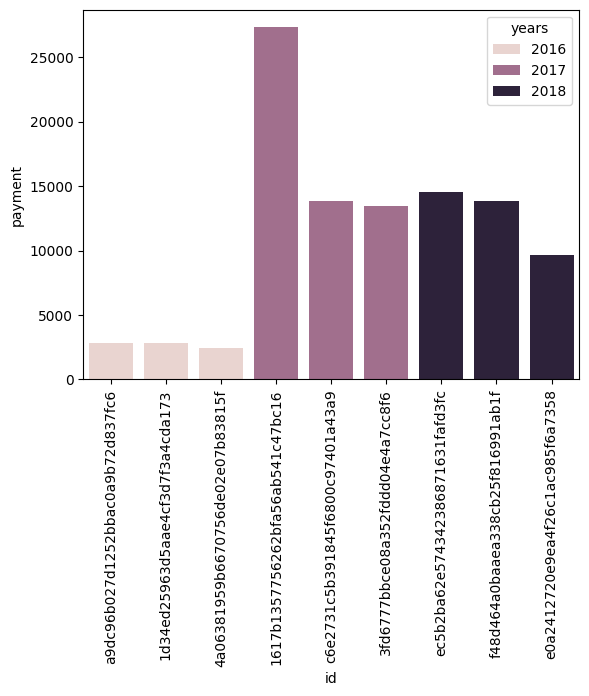

In [12]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()

# Observation 
- For each year, the top 3 customers are identified based on total spending.
- These customers show the highest monetary contribution in their respective years, making them the most valuable customers in the dataset.
- This analysis highlights who drives the most revenue annually, useful for tracking big buyers

# ✅ Final Conclusion

- Sales Trend: Sales increase sharply from 2016 → 2017 but slowed down in 2018.
- Top Categories: A few categories (Bed Table Bath, Health Beauty, Computer Accessories, etc.) contribute the majority of sales, showing high category concentration.
- State-wise Customers: Most customers come from SP, RJ, and MG, with lower participation from smaller states.
- Price vs Purchases: Correlation is -0.106, meaning price has almost no effect on how often products are bought.
- Top Sellers: The top 10 sellers generate the most revenue, with the leading seller far ahead of others.
- Customer Retention: Retention within 6 months is 0%, indicating customers purchase only once in the dataset.
- High-Value Customers: The top 3 spenders each year were identified, showing the customers who contribute the most to yearly revenue.